In [132]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 66

# 各パス指定

In [133]:
dataset = 'model/pose_classifier/squat_pose.csv'
model_save_path = 'model/pose_classifier/squat5_pose_classifier.hdf5'

# 分類数設定

In [134]:
NUM_CLASSES = 4

# 学習データ読み込み

In [135]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, 66 + 1)))

In [136]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [138]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((66, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [139]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_14 (Dropout)        (None, 66)                0         
                                                                 
 dense_21 (Dense)            (None, 20)                1340      
                                                                 
 dropout_15 (Dropout)        (None, 20)                0         
                                                                 
 dense_22 (Dense)            (None, 10)                210       
                                                                 
 dense_23 (Dense)            (None, 4)                 44        
                                                                 
Total params: 1,594
Trainable params: 1,594
Non-trainable params: 0
_________________________________________________________________


In [140]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [141]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [142]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 1/17 [>.............................] - ETA: 6s - loss: 1.3783 - accuracy: 0.3281
Epoch 1: saving model to model/pose_classifier\squat5_pose_classifier.hdf5
17/17 [==============================] - 1s 10ms/step - loss: 1.3338 - accuracy: 0.4003 - val_loss: 1.2571 - val_accuracy: 0.5154
Epoch 2/1000
 1/17 [>.............................] - ETA: 0s - loss: 1.3522 - accuracy: 0.3906
Epoch 2: saving model to model/pose_classifier\squat5_pose_classifier.hdf5
17/17 [==============================] - 0s 4ms/step - loss: 1.2535 - accuracy: 0.4993 - val_loss: 1.1935 - val_accuracy: 0.5154
Epoch 3/1000
 1/17 [>.............................] - ETA: 0s - loss: 1.2495 - accuracy: 0.5078
Epoch 3: saving model to model/pose_classifier\squat5_pose_classifier.hdf5
17/17 [==============================] - 0s 4ms/step - loss: 1.2224 - accuracy: 0.5072 - val_loss: 1.1634 - val_accuracy: 0.5154
Epoch 4/1000
 1/17 [>.............................] - ETA: 0s - loss: 1.1522 - accuracy: 0.5859
Epo

In [143]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

6/6 [==============================] - 0s 1ms/step - loss: 0.0178 - accuracy: 1.0000


In [144]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [145]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 38ms/step
[1.4094430e-05 9.9995065e-01 3.4998211e-05 2.2761412e-07]
1


# 混同行列

23/23 [==============================] - 0s 881us/step


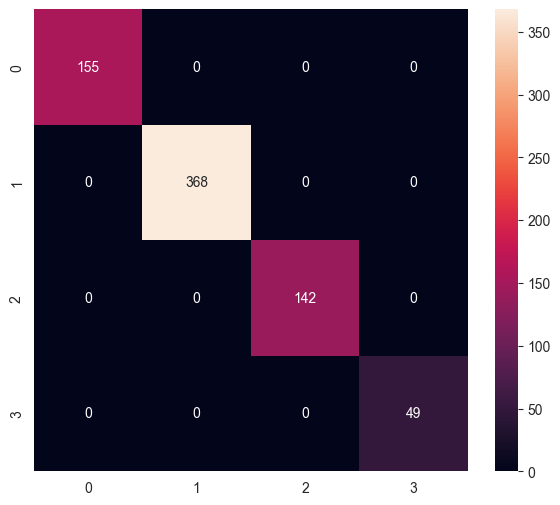

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       155
           1       1.00      1.00      1.00       368
           2       1.00      1.00      1.00       142
           3       1.00      1.00      1.00        49

    accuracy                           1.00       714
   macro avg       1.00      1.00      1.00       714
weighted avg       1.00      1.00      1.00       714



In [146]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [147]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)

In [148]:
# モデルを変換(量子化)
tflite_save_path = 'model/pose_classifier/squat5_pose_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\SSAFY\AppData\Local\Temp\tmphzr6_tsx\assets


INFO:tensorflow:Assets written to: C:\Users\SSAFY\AppData\Local\Temp\tmphzr6_tsx\assets


4672

# 推論テスト

In [149]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [150]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [151]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [152]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [153]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.4632220e-05 9.9995947e-01 2.5661346e-05 2.0909752e-07]
1
